# Cargue y preentrenamiento de datos

In [11]:
Etiquetas_Nombres = ['baseball_diamond', 'Basket', 'Campo_Futbol', 'Cancha_Multiple', 'golf_course','Parque','Tenis']

In [12]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

#***********************************************************************************************************

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Mixta_Propia'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta

#***********************************************************************************************************
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

#***********************************************************************************************************

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'Basket': 1, 'Campo_Futbol': 2, 'Cancha_Multiple': 3,'golf_course': 4,'Parque': 5,'Tenis': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))

#***********************************************************************************************************

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))

#***********************************************************************************************************

# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))



C:\Users\nicol\AppData\Local\Temp\ipykernel_9036\1101011861.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.
Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 240, 1: 233, 2: 240, 3: 267, 4: 250, 5: 230, 6: 242}
Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 267, 1: 267, 2: 267, 3: 267, 4: 267, 5: 267, 6: 267}
Número de ejemplos de entrenamiento antes del balanceo: 1702
Número de ejemplos de entrenamiento después del balanceo: 1869
Número de ejemplos de prueba: 426


# Entrenamiento modelo customizado

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(7, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,935 (60.14 MB)

 Trainable params: 15,764,935 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.2696 - loss: 2.2792 - val_accuracy: 0.6485 - val_loss: 1.0457
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 758ms/step - accuracy: 0.7077 - loss: 0.9042 - val_accuracy: 0.8122 - val_loss: 0.5467
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 745ms/step - accuracy: 0.8687 - loss: 0.4133 - val_accuracy: 0.9706 - val_loss: 0.1657
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 742ms/step - accuracy: 0.9682 - loss: 0.1573 - val_accuracy: 0.9888 - val_loss: 0.0658
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 767ms/step - accuracy: 0.9933 - loss: 0.0567 - val_accuracy: 0.9989 - val_loss: 0.0186
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 769ms/step - accuracy: 0.9962 - loss: 0.0219 - val_accuracy: 0.9989 - val_loss: 0.0101
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 772ms/step - accuracy: 0.9998 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 46s 785ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accu

Precision: 0.7953911143124303
Recall: 0.7934272300469484
F1 Score: 0.7930472713701919
Accuracy: 0.7934272300469484
Classification Report:
                  precision    recall  f1-score   support

baseball_diamond       0.95      0.95      0.95        60
          Basket       0.67      0.67      0.67        67
    Campo_Futbol       0.78      0.67      0.72        60
 Cancha_Multiple       0.68      0.79      0.73        61
     golf_course       0.92      0.94      0.93        50
          Parque       0.83      0.84      0.84        70
           Tenis       0.76      0.72      0.74        58

        accuracy                           0.79       426
       macro avg       0.80      0.80      0.80       426
    weighted avg       0.80      0.79      0.79       426



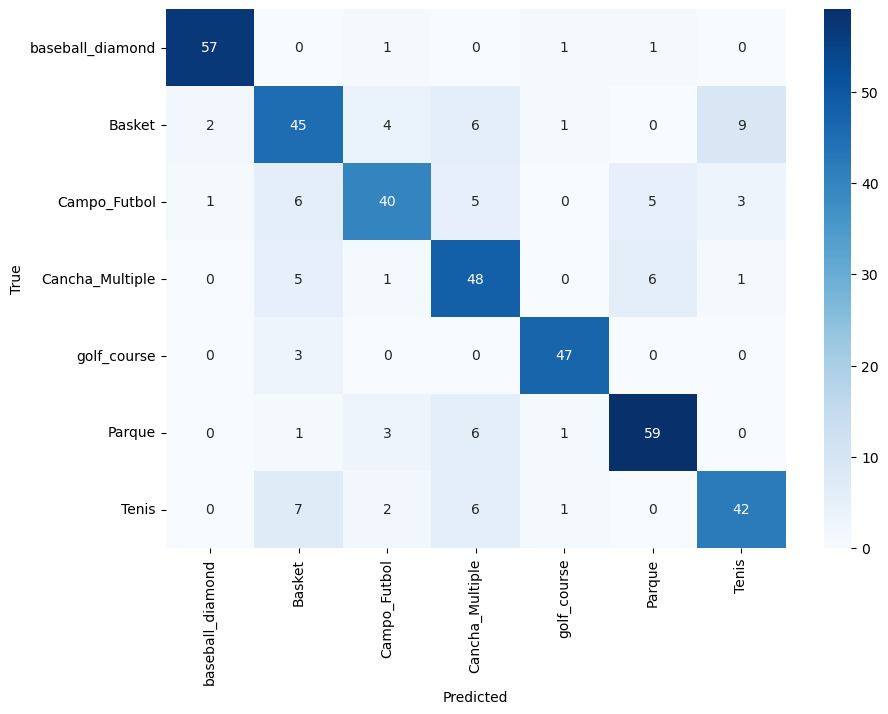

In [16]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [17]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/Mixto/Mixto_Custom.h5')

# Entrenamiento con VGG16

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2856 - loss: 2.8045 - val_accuracy: 0.6009 - val_loss: 1.1706 - learning_rate: 0.0010
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5026 - loss: 1.2622 - val_accuracy: 0.6901 - val_loss: 0.8923 - learning_rate: 0.0010
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.6058 - loss: 0.9846 - val_accuracy: 0.7864 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.6613 - loss: 0.8452 - val_accuracy: 0.8122 - val_loss: 0.5882 - learning_rate: 9.0484e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6993 - loss: 0.7569 - val_accuracy: 0.8216 - val_loss: 0.5872 - learning_rate: 8.1873e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.7276 - loss: 0.6929 - val_accuracy: 0.8239 - val_loss: 0.5046 - learning_rate: 7.4082e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.7502 - loss: 0.61

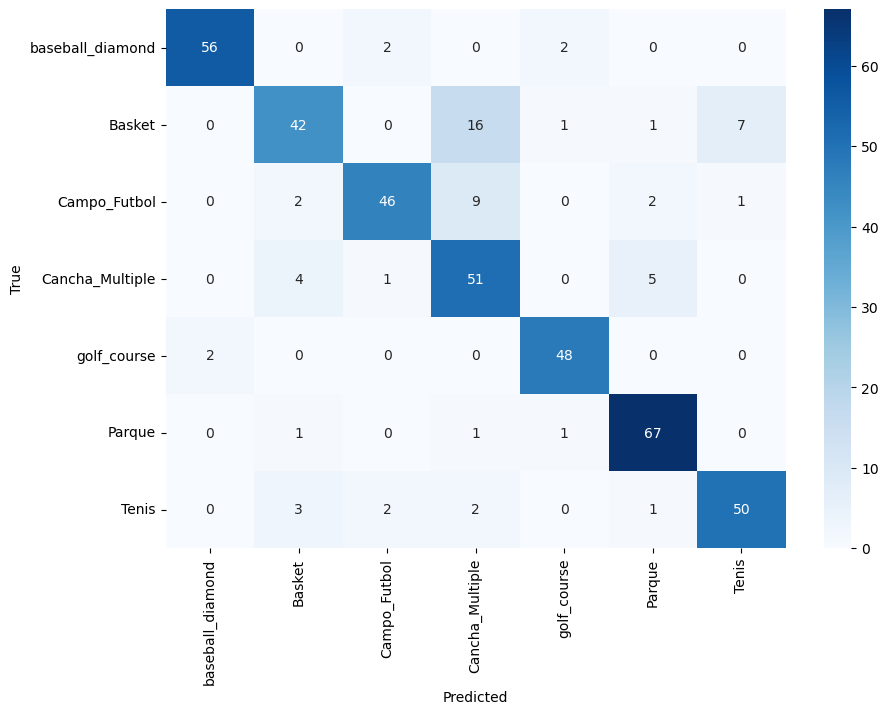

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)



14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Precision: 0.8530708578921254
Recall: 0.8450704225352113
F1 Score: 0.8444160937415403
Accuracy: 0.8450704225352113
Classification Report:
                  precision    recall  f1-score   support

baseball_diamond       0.97      0.93      0.95        60
          Basket       0.81      0.63      0.71        67
    Campo_Futbol       0.90      0.77      0.83        60
 Cancha_Multiple       0.65      0.84      0.73        61
     golf_course       0.92      0.96      0.94        50
          Parque       0.88      0.96      0.92        70
           Tenis       0.86      0.86      0.86        58

        accuracy                           0.85       426
       macro avg       0.86      0.85      0.85       426
    weighted avg       0.85      0.85      0.84       426



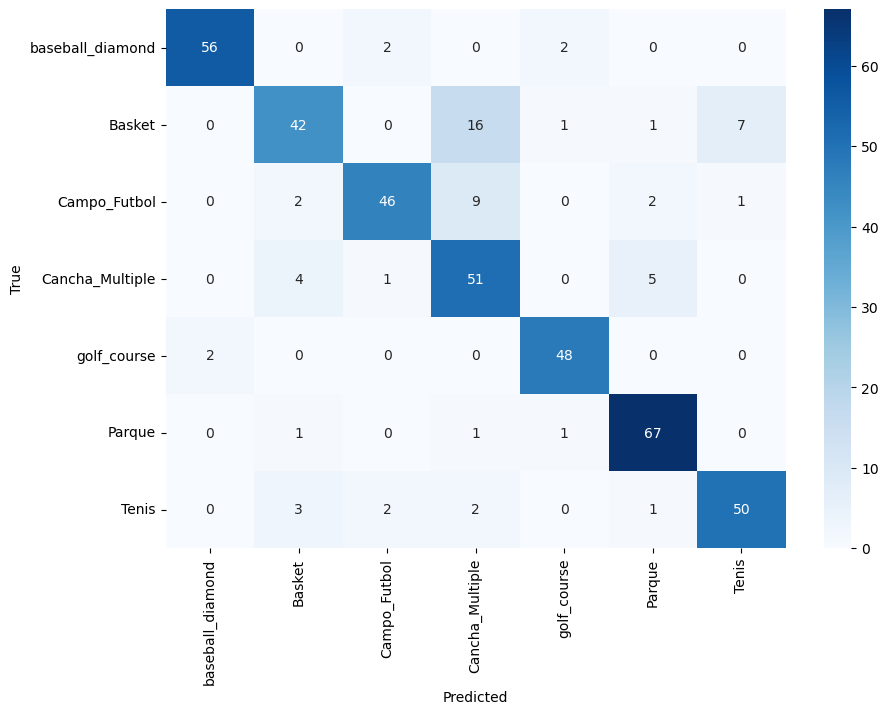

In [20]:
#******************************************************************************************


# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Mixto/Mixto_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí

)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4003 - loss: 6.5142 - val_accuracy: 0.6150 - val_loss: 1.0566 - learning_rate: 0.0010
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.5992 - loss: 1.1102 - val_accuracy: 0.7535 - val_loss: 0.8043 - learning_rate: 0.0010
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.6690 - loss: 0.8761 - val_accuracy: 0.7230 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7140 - loss: 0.7748 - val_accuracy: 0.7911 - val_loss: 0.6751 - learning_rate: 9.0484e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7733 - loss: 0.6665 - val_accuracy: 0.7958 - val_loss: 0.6134 - learning_rate: 8.1873e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7612 - loss: 0.6154 - val_accuracy: 0.7840 - val_loss: 0.5942 - learning_rate: 7.4082e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.7602 - loss: 0.62

14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Precision: 0.8526397198977866
Recall: 0.8474178403755869
F1 Score: 0.8489642110069993
Accuracy: 0.8474178403755869
Classification Report:
                  precision    recall  f1-score   support

baseball_diamond       1.00      0.90      0.95        60
          Basket       0.74      0.78      0.76        67
    Campo_Futbol       0.82      0.78      0.80        60
 Cancha_Multiple       0.68      0.74      0.71        61
     golf_course       0.96      1.00      0.98        50
          Parque       0.85      0.90      0.88        70
           Tenis       0.94      0.86      0.90        58

        accuracy                           0.85       426
       macro avg       0.86      0.85      0.85       426
    weighted avg       0.85      0.85      0.85       426



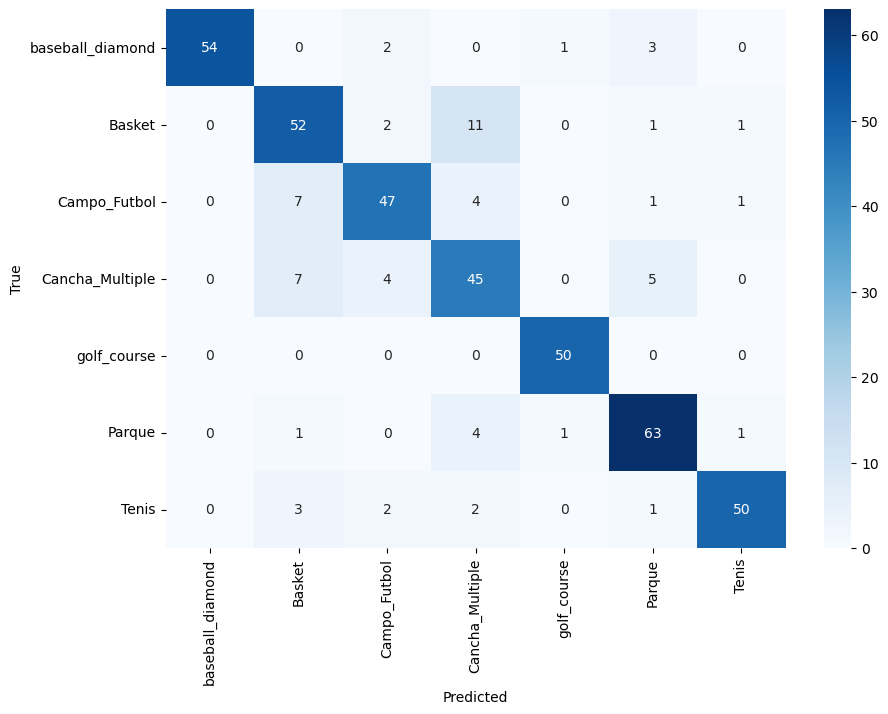

In [25]:
#*********************************************************************************************
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Mixto/Mixto_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [31]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Mixta_Propia'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'Basket': 1, 'Campo_Futbol': 2, 'Cancha_Multiple': 3,'golf_course': 4,'Parque': 5,'Tenis': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5328279460890818
Validation Loss: 0.7000748344830104
Epoch 2, Loss: 0.2894013183096708
Validation Loss: 0.3032607425536428
Epoch 3, Loss: 0.20976598342975317
Validation Loss: 0.14047950812216317
Epoch 4, Loss: 0.06032748963936406
Validation Loss: 0.08592016422855002
Epoch 5, Loss: 0.04201149605056745
Validation Loss: 0.058177841062258394
Epoch 6, Loss: 0.03152396159949002
Validation Loss: 0.04793340639610376
Epoch 7, Loss: 0.01918590278759346
Validation Loss: 0.0499842179373705
Epoch 8, Loss: 0.018723215528969037
Validation Loss: 0.05356101969456566
Epoch 9, Loss: 0.017443286412853306
Validation Loss: 0.04512480801037912
Epoch 10, Loss: 0.02025644794911525
Validation Loss: 0.05871981119603983
Epoch 11, Loss: 0.01679437735386319
Validation Loss: 0.04946274536528757
Epoch 12, Loss: 0.013729483777088887
Validation Loss: 0.04910618015232363
Early stopping triggered


Precision: 0.9886390442327165
Recall: 0.9882629107981221
F1 Score: 0.988268539129904
Accuracy: 0.9882629107981221
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       1.00      0.98      0.99        60
  basketball_court       1.00      0.96      0.98        67
       golf_course       0.98      0.98      0.98        60
ground_track_field       0.95      1.00      0.98        61
              park       0.98      1.00      0.99        50
           stadium       1.00      1.00      1.00        70
      tennis_court       1.00      1.00      1.00        58

          accuracy                           0.99       426
         macro avg       0.99      0.99      0.99       426
      weighted avg       0.99      0.99      0.99       426



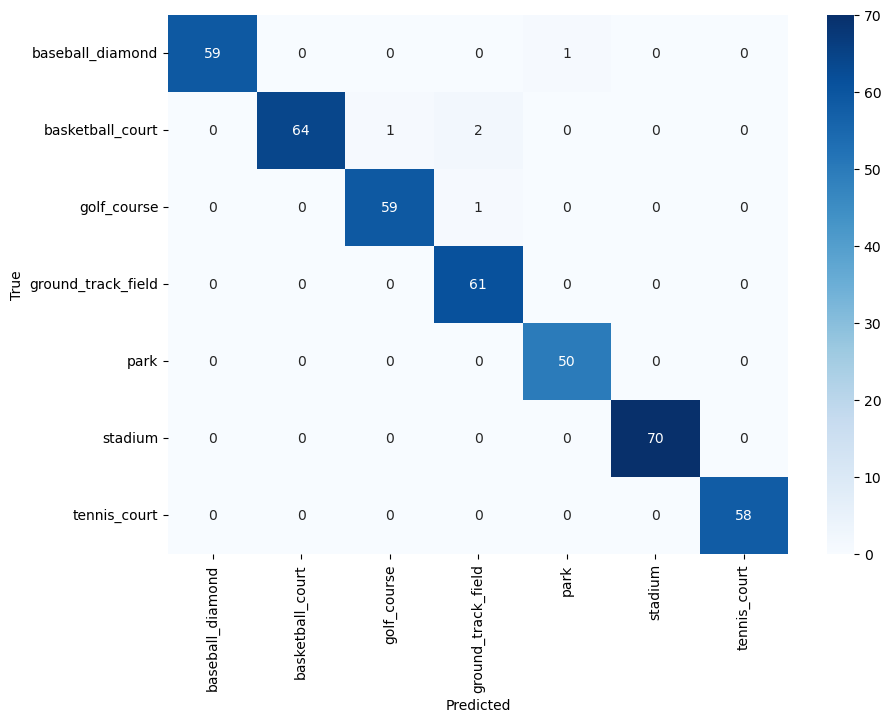

In [32]:
# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [33]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Mixto/Mixto_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [34]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Mixta_Propia'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'Basket': 1, 'Campo_Futbol': 2, 'Cancha_Multiple': 3,'golf_course': 4,'Parque': 5,'Tenis': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5913225447727462
Validation Loss: 0.7954422969903264
Epoch 2, Loss: 0.23120541996875052
Validation Loss: 0.39457049114363535
Epoch 3, Loss: 0.28835817363302585
Validation Loss: 3.5625460062708174
Epoch 4, Loss: 0.11118188569069666
Validation Loss: 0.11142500173965735
Epoch 5, Loss: 0.048270152936989476
Validation Loss: 0.08944409590081445
Epoch 6, Loss: 0.03281806301625477
Validation Loss: 0.08668074738566897
Epoch 7, Loss: 0.0223480651502387
Validation Loss: 0.07557929927549724
Epoch 8, Loss: 0.024434667518678104
Validation Loss: 0.08045043036275144
Epoch 9, Loss: 0.023275778877501516
Validation Loss: 0.07988526859220915
Epoch 10, Loss: 0.01788904719938666
Validation Loss: 0.07371584743460906
Epoch 11, Loss: 0.026183370729687357
Validation Loss: 0.07522680686919817
Epoch 12, Loss: 0.020406305367695325
Validation Loss: 0.07884500179040645
Epoch 13, Loss: 0.01916186475605404
Validation Loss: 0.08090480002907238
Early stopping triggered


Precision: 0.9752104520906009
Recall: 0.9741784037558685
F1 Score: 0.9741105343438353
Accuracy: 0.9741784037558685
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       1.00      0.97      0.98        60
  basketball_court       1.00      0.91      0.95        67
       golf_course       0.95      1.00      0.98        60
ground_track_field       0.94      0.97      0.95        61
              park       0.94      1.00      0.97        50
           stadium       0.99      0.99      0.99        70
      tennis_court       1.00      1.00      1.00        58

          accuracy                           0.97       426
         macro avg       0.97      0.98      0.97       426
      weighted avg       0.98      0.97      0.97       426



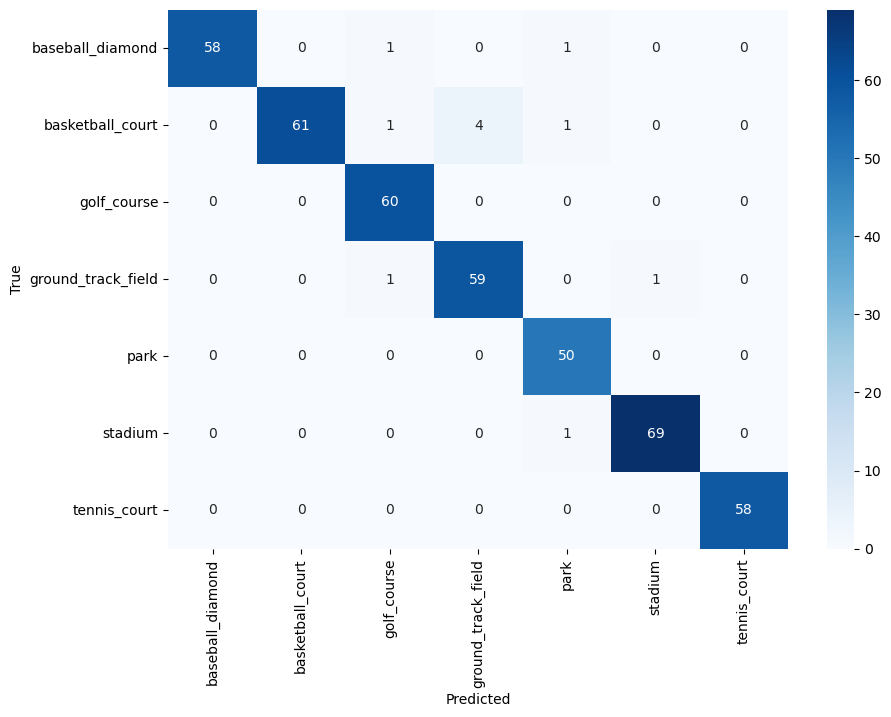

In [35]:

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [36]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Mixto/Mixto_ResNET18.pth')